/!\    Important : à la fin de la séance déposez votre travail sur la page e-campus du cours en un seul fichier nommé  votrenom.ipynb  /!\
              

# Algorithmes de gradient (GD) de gradient stochastique (SGD) pour la régression en grande dimension

Dans ce TP, nous allons utiliser  la technique du gradient et gradient stochastique pour résoudre la régression Ridge

\begin{equation}
\min_x f(x):=\frac{1}{2n}\|Ax-b\|^2+\frac{\gamma}{2} \|x\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2+\frac{\gamma}{2} \|x\|^2 \qquad\qquad (1_\gamma)
\end{equation}
où $A\in\mathbb{R}^{n\times d}$, $b\in\mathbb{R}^n$ et $\gamma$ est un paramètre de régularisation positif.
C'est une régression linéaire avec "une contrainte" quadratique sur les coefficients.
Ce terme est ajouté pour pallier la présence de colinéarité de certaines variables explicatives (ce qui est probable lorsque il a beaucoup de variables). Il vise aussi à empêcher le modèle de sur-ajuster les données.

La solution de ($1_\gamma$) peut s’exprimer de façon exacte
$$x^* = (A^TA+ \gamma I)^{-1} A^Tb.$$
On voit qu’il est possible de choisir un $\gamma$ pour lequel la matrice $A^TA+\gamma I$ est inversible. 
En grande dimension en revanche, l'inversion de cette matrice n'est pas possible et un gradient stochastique est utilisé à la place.

On signale que la fonction $f$ est $\mu$ fortement convexe avec $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)+\gamma$  et à gradient $L$-Lipschitz avec $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)+\gamma$.

Nous allons procéder en en plusieurs étapes :

- Charger les données qui vont nous servir pour tester nos algorithmes. Construire la matrice $A$ et el vecteur $b$ associés. Calculer les valeurs des constantes $\mu$  et $L$
- Implémenter et tester l'algorithme de gradient sur ce jeu de données
- Implémenter et tester l'algorithme de gradient stochastique sur ce jeu de données
- Observer le rôle du paramètre $\gamma.$

Nous allons d'abord charger quelques packages utiles :

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Chargement des données


On veut prédire la pression acoustique (sound pressure $SSPL$) générée par une voilure (aile par exemple) à partir de plusieurs entrées mesurées :


![airfold.png](airfold.png)

1. Frequency, in Hertz ($f$).
2. Angle of attack, in degrees ($\alpha$).
3. Chord length, in meters ($c$).
4. Free-stream velocity, in meters per second ($u_\infty$).
5. Suction side displacement thickness, in  ($\delta$).

Nous cherchons une relation de la forme 
$$ SSPL= a_0+a_1 f+ a_2\alpha + a_3 c+ a_4 u_\infty + a_5\delta$$

Nous allons d'abord charger les données contenues dans le fichiers airfoil_train.csv et airfoil_test.csv. Les premières serviront à apprendre les coefficients et les secondes pour evaluer l'erreur du modèle sur des nouvelles données.

In [3]:
import pandas as pd 

df = pd.read_csv("airfoil_train.csv",delimiter="\t", usecols=[0, 1, 2, 3, 4, 5])

b = df['SndPres'].to_numpy()
a = df[['Freq', 'Angle', 'ChordL', 'Veloc', 'SucThick']].to_numpy()

num_samples =len(b)
mean_a= np.mean(a)
std_a = np.std(a)
a = a - mean_a
a = a / std_a
A = np.c_[np.ones(num_samples), a]
lmax=max(np.linalg.eig(A.T@A)[0])/len(b)
lmin=min(np.linalg.eig(A.T@A)[0])/len(b)
print(lmax)
print(lmin)

5.190304125830141
1.0535773287768708e-11


## Algorithme de gradient

Compléter les fonctions python suivantes qui implémentent respectivement la fonction-objectif et son gradient.

In [4]:
def obj_fun(A,b,gamma,x):
    ''' x est un np.array'''
    n = len(b)
    return (1/(2*n)) * np.linalg.norm(A @ x - b)**2 + (gamma/2) * np.linalg.norm(x)**2

def gd_obj_fun(A,b,gamma,x):
    ''' x est un np.array'''
    n = len(b)
    return (1/n) * A.T @ (A @ x - b) + gamma * x

Compléter l’implémentation de l'algorithme de gradient avec pas constant pour résoudre le problème ($1_\gamma$). 

In [5]:
def algoGD(A, b, gamma, x0, pas, epsilon, nIterMax):
    ''' Algo de GRADIENT pour resoudre le probleme 1_gamma
    - x0                  point de depart : np.array : R^n
    - pas                 valeur du pas   
    - espsilon, nIterMax  pour les criteres d'arrets
     Sorties :  
    -X =[x0,....xk] :  liste qui contient les iteres xk
    -F = [f(x0),....f(xk)] :  liste des valeurs de f au cours des iterations en xk 
    '''
    X = [x0]
    F = [obj_fun(A, b, gamma, x0)]
    for k in range(nIterMax):
        dk = gd_obj_fun(A, b, gamma, X[k])
        f = obj_fun(A, b, gamma, X[k])
        x = X[k] - pas * dk
        X.append(x)
        F.append(f)
    
    return X, F

Tester cet algorithme sur les données chargées ci-dessus en choisissant $\gamma=0$.

In [6]:
gamma =0.0001
x0 = np.zeros(A.shape[1])
pas=  0.1
epsilon=  0.00001
nIterMax= 10000
X,F= algoGD(A,b,gamma,x0, pas, epsilon,nIterMax)


Ici peut calculer analytiquement $x^*$. Traçons la courbe $f(x_k)-f(x^*)$ en fonction du nombre d'itérations.

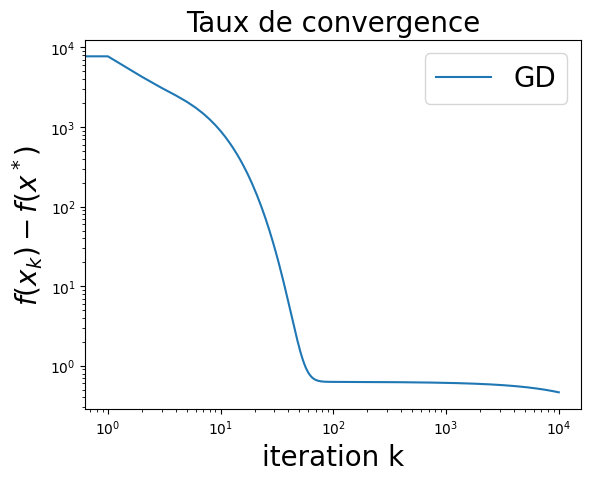

In [7]:
x_star = np.linalg.solve(A.T@A/A.shape[0]+ gamma*np.eye(A.shape[1]), A.T@b/A.shape[0])
best_obj= obj_fun(A,b,gamma,x_star)
plt.title('Taux de convergence', fontsize = 20)
plt.loglog(F-best_obj,label='GD')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## Algorithme de gradient stochastique

En vous inspirant de ce qui précède implémenter l'algorithme de gradient stochastique (Algorithme 5, page 182 du polycopié). On prendra un pas constant. Faire des tests avec $\gamma\in\{0, 0.0001\}$.

In [22]:
def sgd_obj_fun(A,b,gamma,x):
    ''' x est un np.array'''
    n = len(b)
    i = np.random.randint(n)
    return A[i].T * (A[i] @ x - b[i]) + gamma * x

In [46]:
def algoSGD(A, b, gamma, x0, pas, nIterMax):
    ''' Algo de GRADIENT STOCHASTIQUE pour resoudre le probleme 1_gamma
    - x0                  point de depart : np.array : R^n
    - pas                 valeur du pas   
    - nIterMax            nombre maximal d'iterations
     Sorties :  
    - Xs = [x0,....xk] :  liste qui contient les iteres xk
    - Fs = [f(x0),....f(xk)] :  liste des valeurs de f au cours des iterations en xk 
    - BestFs = [min(f(x0),...,f(xk))] : liste des meilleures valeurs de f jusqu'a l'iteration k
    '''
    X = [x0]
    F = [obj_fun(A, b, gamma, x0)]
    bestF = [F[0]]
    for k in range(nIterMax):
        gk = sgd_obj_fun(A, b, gamma, X[k])
        f = obj_fun(A, b, gamma, X[k])
        x = X[k] - pas * gk
        X.append(x)
        F.append(f)
        bestF.append(min(f, bestF[k]))
    
    return X, F, bestF

In [47]:
gamma = 0.0001
x0 = np.zeros(A.shape[1])
pas= 0.1
nIterMax= 10000
Xs,Fs, BestFs = algoSGD(A,b,gamma,x0, pas,nIterMax)

Traçons les courbes de $f(x_k)-f(x^*)$ et de $\min_{i\leq k} f(x_i) -f(x^*)$ en fonction du nombre d'itérations $k$.

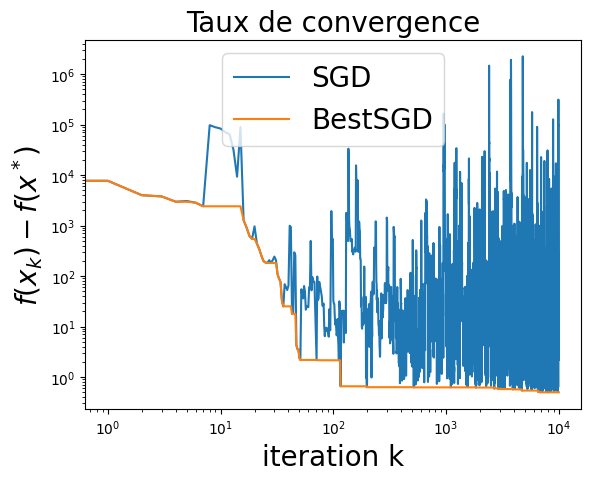

In [48]:
x_star = np.linalg.solve(A.T@A/A.shape[0]+ gamma*np.eye(A.shape[1]), A.T@b/A.shape[0])
best_obj= obj_fun(A,b,gamma,x_star)
plt.title('Taux de convergence', fontsize = 20)
plt.loglog(Fs-best_obj, label='SGD')
plt.loglog(BestFs-best_obj, label='BestSGD')
plt.xlabel('iteration k'  , fontsize = 20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

# Intérêt de la régularisation
On charge maintenant un nouveau jeu de données pour evaluer la qualité du modèle obtenu et observer le rôle du paramètre $\gamma$. 

In [ ]:
import pandas as pd 

dft = pd.read_csv("airfoil_test.csv",delimiter="\t", usecols=[0, 1, 2, 3, 4, 5])

bt = dft['SndPres'].to_numpy()
at = dft[['Freq', 'Angle', 'ChordL', 'Veloc', 'SucThick']].to_numpy()

num_samples_test =len(at)
mean_at= np.mean(at)
std_at = np.std(at)
at = at - mean_at
at = at / std_at
At = np.c_[np.ones(num_samples_test), at]



gamma=0
x_star = np.linalg.solve(A.T@A/A.shape[0]+ gamma*np.eye(A.shape[1]), A.T@b/A.shape[0])


print("Erreur moyenne sur la base d'apprentissage avec gamma ={a:10.4f} est {b:10.2f}".format(a=gamma, b=np.mean((A@x_star-b)**2))) 
print("Erreur moyenne sur la base de test avec gamma ={a:10.4f} est {b:10.2f}".format(a=gamma, b=
                                                                                      np.mean((At@x_star-bt)**2))) 

gamma=0.0001
x_star = np.linalg.solve(A.T@A/A.shape[0]+ gamma*np.eye(A.shape[1]), A.T@b/A.shape[0])
print("Erreur moyenne sur la base d'apprentissage avec gamma ={a:10.4f} est {b:10.2f}".format(a=gamma, b=np.mean((A@x_star-b)**2))) 
print("Erreur moyenne sur la base de test avec gamma ={a:10.4f} est {b:10.2f}".format(a=gamma, b=
                                                                                      np.mean((At@x_star-bt)**2))) 


## Aller plus loin
Proposer une implémentation de l'algorithme de gradient stochastique qui utilise plusieurs données (un mini-batch) au lieu d'utiliser qu'une seule donnée. Comparer avec l'algorithme précédent

In [64]:
import numpy as np

def mini_batch_sgd_obj_fun(A, b, gamma, x, batch_size):
    ''' x est un np.array'''
    n = len(b)
    indices = np.random.choice(n, batch_size, replace=False)
    A_batch = A[indices]
    b_batch = b[indices]
    gradient = A_batch.T @ (A_batch @ x - b_batch) / batch_size + gamma * x
    return gradient

In [65]:
def algoMiniBatchSGD(A, b, gamma, x0, pas, nIterMax, batch_size):
    ''' Algo de GRADIENT STOCHASTIQUE avec mini-batch pour resoudre le probleme 1_gamma
    - x0                  point de depart : np.array : R^n
    - pas                 valeur du pas   
    - nIterMax            nombre maximal d'iterations
    - batch_size          taille du mini-batch
     Sorties :  
    - Xs = [x0,....xk] :  liste qui contient les iteres xk
    - Fs = [f(x0),....f(xk)] :  liste des valeurs de f au cours des iterations en xk 
    - BestFs = [min(f(x0),...,f(xk))] : liste des meilleures valeurs de f jusqu'a l'iteration k
    '''
    X = [x0]
    F = [obj_fun(A, b, gamma, x0)]
    bestF = [F[0]]
    for k in range(nIterMax):
        gk = mini_batch_sgd_obj_fun(A, b, gamma, X[k], batch_size)
        f = obj_fun(A, b, gamma, X[k])
        x = X[k] - pas * gk
        X.append(x)
        F.append(f)
        bestF.append(min(f, bestF[k]))
    
    return X, F, bestF

In [68]:
# Parameters
gamma = 0.0001
x0 = np.zeros(A.shape[1])
pas = 0.1
nIterMax = 10000
batch_size = 200

# Run single data point SGD
Xs_sgd, Fs_sgd, BestFs_sgd = algoSGD(A, b, gamma, x0, pas, nIterMax)

# Run mini-batch SGD
Xs_mini_batch, Fs_mini_batch, BestFs_mini_batch = algoMiniBatchSGD(A, b, gamma, x0, pas, nIterMax, batch_size)



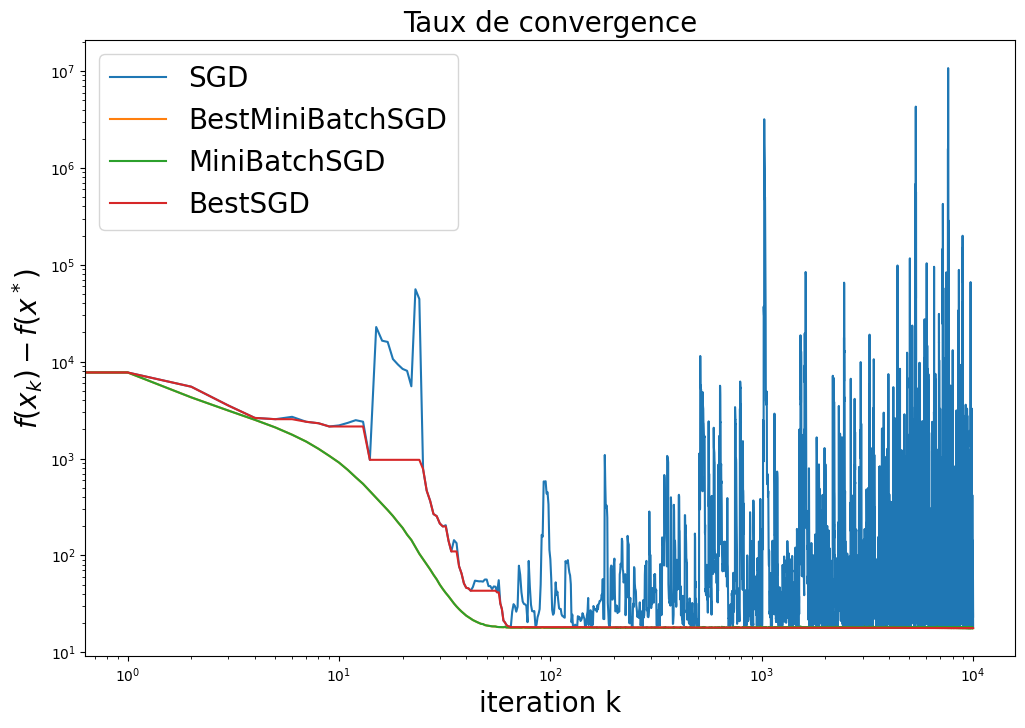

In [69]:
# Plotting the results with an enlarged window
x_star = np.linalg.solve(A.T@A/A.shape[0]+ gamma*np.eye(A.shape[1]), A.T@b/A.shape[0])
best_obj = obj_fun(A, b, gamma, x_star)

plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
plt.title('Taux de convergence', fontsize=20)
plt.loglog(Fs_sgd, label='SGD')
plt.loglog(BestFs_mini_batch, label='BestMiniBatchSGD')
plt.loglog(Fs_mini_batch, label='MiniBatchSGD')
plt.loglog(BestFs_sgd, label='BestSGD')
plt.xlabel('iteration k', fontsize=20)
plt.ylabel(r'$f(x_k) - f(x^*)$', fontsize=20)
plt.legend(fontsize=20)
plt.show()